In [1]:
# for loading data
import numpy as np
import pandas as pd
import os
# for visualization
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'Arial'
from scipy.stats import mannwhitneyu
import seaborn as sns
# for classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score

In [2]:
# load Gevers data
raw = pd.read_excel('./RawData/Gevers/Gevers_remove_missing.xlsx', sheet_name='Sheet2')
# gevers_data.head()
# gevers_data.columns.tolist().index('Control')  # 394
cd_gevers_data = raw.iloc[:, 3:393]
cd_gevers_data.index = raw.iloc[:, 2].tolist()
cd_gevers_data = cd_gevers_data.T
cd_gevers_data = cd_gevers_data.loc[cd_gevers_data.isna().sum(axis=1) < 60]
print(cd_gevers_data.shape)
# cd_gevers_data.head(2)
ctl_gevers_data = raw.iloc[:, 395:]
ctl_gevers_data.index = raw.iloc[:, 2].tolist()
ctl_gevers_data = ctl_gevers_data.T
ctl_gevers_data = ctl_gevers_data.loc[ctl_gevers_data.isna().sum(axis=1) < 60]
print(ctl_gevers_data.shape)
# ctl_gevers_data.head(2)

Gevers_data = pd.concat([cd_gevers_data, ctl_gevers_data], axis=0)
Gevers_data.index = Gevers_data.index.map(lambda item: item.strip())
Gevers_data['label'] = [1] * len(cd_gevers_data) + [0] * len(ctl_gevers_data)
print(Gevers_data.shape)

(388, 69)
(38, 69)
(426, 70)


### Mann-Whitney U rank test

In [3]:
# Mann-Whitney U rank test
tmp = cd_gevers_data['Lactobacillus'].values
Lactobacillus_cd = tmp[~np.isnan(tmp)]
# Lactobacillus_cd
tmp1 = ctl_gevers_data['Lactobacillus'].values
Lactobacillus_ctl = tmp1[~np.isnan(tmp1)]
mannwhitneyu(Lactobacillus_cd, Lactobacillus_ctl, alternative='less')

MannwhitneyuResult(statistic=1079.0, pvalue=6.04307731805369e-05)

In [4]:
mark = Gevers_data.columns.tolist().index('Lactobacillus')
print(mark)

51


0.7558354316222066 Streptococcus
0.7782911043461025 Parasutterella
0.880958293303492 Escherichia
0.8893029969909568 Coprobacillus
0.9024458267441372 Bifidobacterium
1.0479620108956953 Unknown
1.2711127712244452 Veillonella
1.3332411902028818 Cellulosilyticum
1.816702083495738 Anaerostipes
3.12299504270989 Lactobacillus


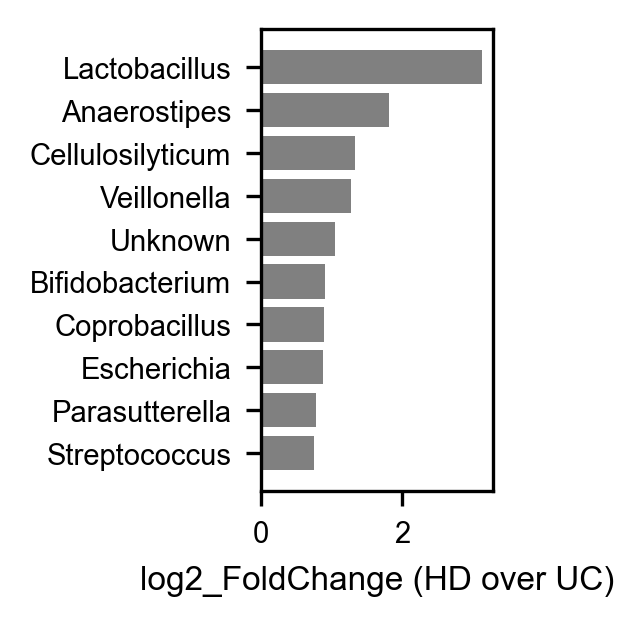

In [5]:
# fold change of each flora
flora_fcs = []
for i in range(cd_gevers_data.shape[1]):
    cd = cd_gevers_data.iloc[:, i].values
    cd_valid = cd[~np.isnan(cd)]
    ctl = ctl_gevers_data.iloc[:, i].values
    ctl_valid = ctl[~np.isnan(ctl)]

    fc = np.mean(ctl_valid) / np.mean(cd_valid)
    flora_fcs.append(fc)

log_flora_fcs = np.log2(flora_fcs)
# log_flora_fcs.argsort()
for index in log_flora_fcs.argsort()[-10:]:
    print(log_flora_fcs[index], cd_gevers_data.columns.tolist()[index])

neg_log_fcs = np.sort(log_flora_fcs)[-10:]
neg_floras = [cd_gevers_data.columns.tolist()[index] for index in log_flora_fcs.argsort()[-10:]]

plt.figure(figsize=(1, 2), dpi=300)
plt.barh(np.arange(10), neg_log_fcs, color='gray')
# plt.barh(np.arange(5), pos_log_fcs)
plt.yticks(np.arange(10), labels= neg_floras)
plt.xlabel('log2_FoldChange (HD over UC)', fontsize=8)
plt.tick_params(labelsize=7)
# plt.savefig('./figures/GMrepo_foldchange_top10.png', dpi=300, bbox_inches='tight')
plt.show()

2.8917828481669137 Clostridium
2.9421606539216762 Streptococcus
3.1101943946644535 Megasphaera
3.1711786054962263 Lactococcus
3.3085702511596207 Blautia
4.034141243569695 Coprobacillus
4.218741849142367 Lactobacillus
4.93816619746617 Bifidobacterium
5.515450332908149 Anaerostipes
6.356319964292243 Unknown


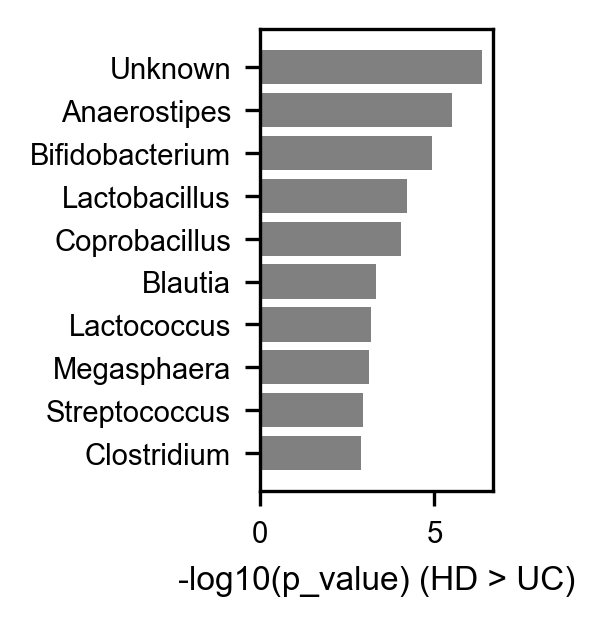

In [6]:
# p_value of Wilcoxon test
flora_p_values = []
for i in range(cd_gevers_data.shape[1]):
    cd = cd_gevers_data.iloc[:, i].values
    cd_valid = cd[~np.isnan(cd)]
    ctl = ctl_gevers_data.iloc[:, i].values
    ctl_valid = ctl[~np.isnan(ctl)]

    # fc = np.mean(hd_valid) / np.mean(uc_valid)
    _, p = mannwhitneyu(ctl_valid, cd_valid, alternative='greater')
    flora_p_values.append(-np.log10(p))
flora_p_values = np.array(flora_p_values)
for index in flora_p_values.argsort()[-10:]:
    print(flora_p_values[index], cd_gevers_data.columns.tolist()[index])

greater_p_values = np.sort(flora_p_values)[-10:]
greater_floras = [cd_gevers_data.columns.tolist()[index] for index in flora_p_values.argsort()[-10:]]
plt.figure(figsize=(1, 2), dpi=300)
plt.barh(np.arange(10), greater_p_values, color='gray')
# plt.barh(np.arange(5), pos_log_fcs)
plt.yticks(np.arange(10), labels= greater_floras)
plt.xlabel('-log10(p_value) (HD > UC)', fontsize=8)
plt.tick_params(labelsize=7)
# plt.savefig('./figures/GMrepo_Wilcoxon_pvalue_top10.png', dpi=300, bbox_inches='tight')
plt.show()

### Train a new LR model with Gevers data

In [7]:
# using C=10, penalty='l1' as hyperparameters
def classification_kfold(all_data, seed, print_res=True):
    features = all_data.iloc[:, :-1].values
    labels = all_data.iloc[:, -1].values

    saved_data = all_data.copy()
    test_aucs = []
    roc_data = []
    weights_list = []
    # using StratifiedKFold
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    for i, (train_index, test_index) in enumerate(kf.split(features, labels)):
        train_x, test_x = features[train_index], features[test_index]
        train_y, test_y = labels[train_index], labels[test_index]
        split_details = ['train' if i in train_index else 'test' for i in range(len(features))]

        scaler = MinMaxScaler(feature_range=(0,1), clip=True)
        pipe = Pipeline([('impute', SimpleImputer(strategy='constant', fill_value=0.)), ('scaler', scaler)])
        X = pipe.fit_transform(train_x)
        test_X = pipe.transform(test_x)

        model = LogisticRegression(penalty='l1', C=10, solver='liblinear', random_state=seed, max_iter=1000)
        model.fit(X, train_y)
        
        logits = model.predict_proba(test_X)[:, 1]
        test_auc = roc_auc_score(test_y, logits)

        fpr, tpr, _ = roc_curve(test_y, logits)
        # train_logits = model.predict_proba(X)[:, 1]
        # train_auc = roc_auc_score(train_y, train_logits)
        # print(train_auc)

        # feature weights
        weights = model.coef_[0]
        argsort_weights = weights.argsort()
        rank = list(argsort_weights).index(mark)
        if print_res:
            print(rank, weights[mark], test_auc)

        test_aucs.append(test_auc)
        weights_list.append(weights)
        roc_data.append((fpr, tpr))
        saved_data[f'{seed}_fold_{i}'] = split_details
    
    mean_weights = np.stack(weights_list).mean(axis=0)
    rank = mean_weights.argsort()
    if print_res:
        print(np.mean(test_aucs))
        print(list(rank).index(mark))

    return saved_data, roc_data, mean_weights, np.mean(test_aucs)

In [8]:
saved_data, roc_data, mean_weights, mean_auc = classification_kfold(Gevers_data, seed=42, print_res=True)

1 -5.499812067066296 0.7371794871794872
0 -7.189277221329386 0.9551282051282051
0 -9.460285157069372 0.9230769230769231
0 -7.837640523583313 0.8333333333333334
0 -8.759395908803025 0.6987179487179487
0 -6.977701092216133 0.9551282051282051
0 -8.174836514853101 0.8974358974358974
0 -8.014568639049376 0.9487179487179488
0 -7.939835977530923 0.8947368421052632
0 -7.343907963231055 0.756578947368421
0.8600033738191633
0


In [9]:
saved_data.to_csv('./model/Gevers_train_test_data.csv')

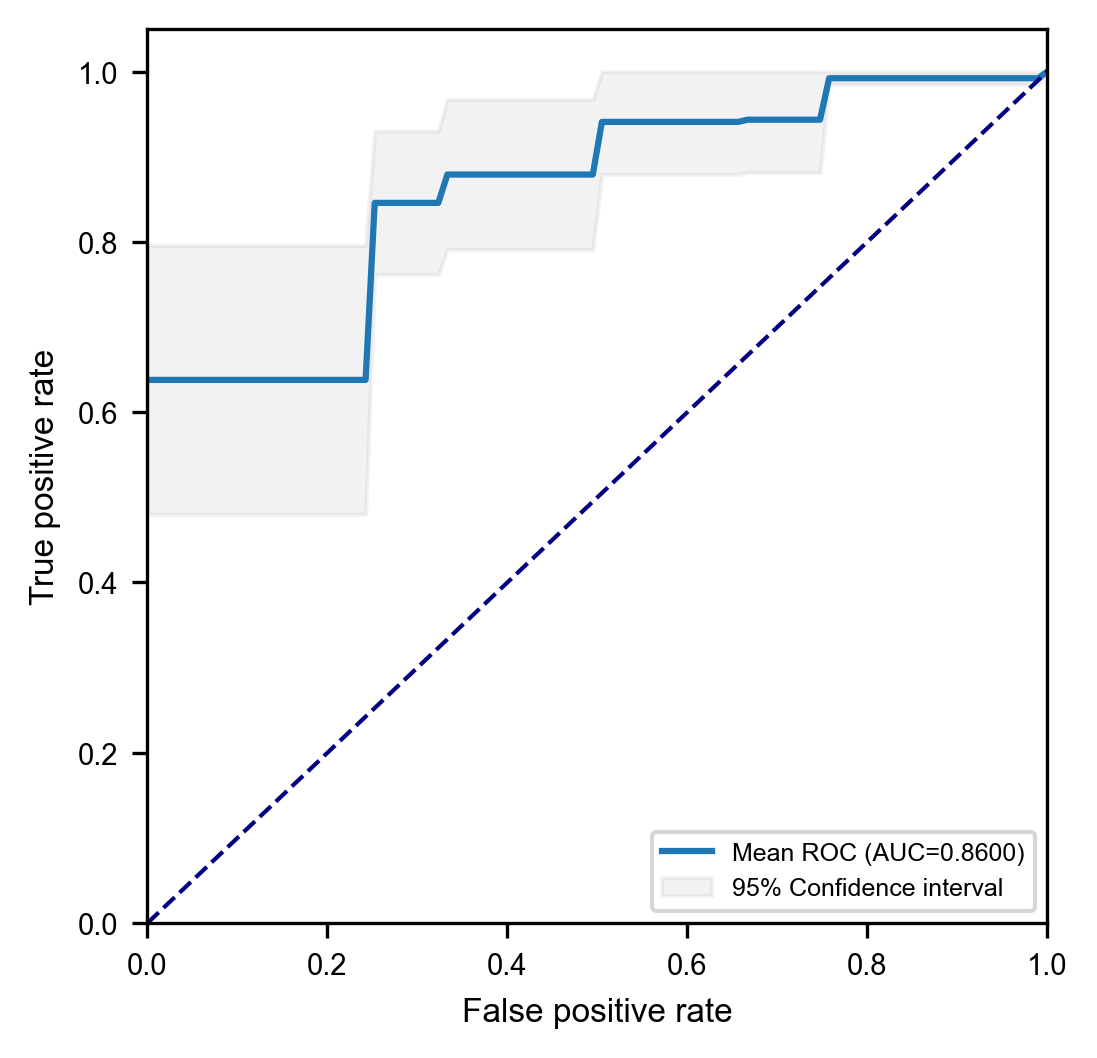

In [9]:
# plot
fig = plt.figure(figsize=(3.87,3.87), dpi=300)

# valid roc
ax = fig.add_subplot(111)
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in roc_data], axis=0)
# 计算置信区间
tpr_std = np.std([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in roc_data], axis=0)
tpr_upper = np.minimum(mean_tpr + 1.96 * tpr_std / np.sqrt(10), 1)
tpr_lower = mean_tpr - 1.96 * tpr_std / np.sqrt(10)
# 绘制平均ROC曲线
plt.plot(mean_fpr, mean_tpr, label='Mean ROC (AUC=0.8600)')
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.1, label='95% Confidence interval')

ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False positive rate', fontdict={'fontsize':8})
ax.set_ylabel('True positive rate', fontdict={'fontsize':8})
ax.tick_params(labelsize=7)
# ax.set_title('Receiver Operating Curve of Valid Dataset')
# ax.set_title('Receiver Operating Curve of Test Dataset')
ax.legend(fontsize=6, loc='lower right')

plt.savefig('./figures/Gevers_mean_roc_curve.png', dpi=300)
plt.show()

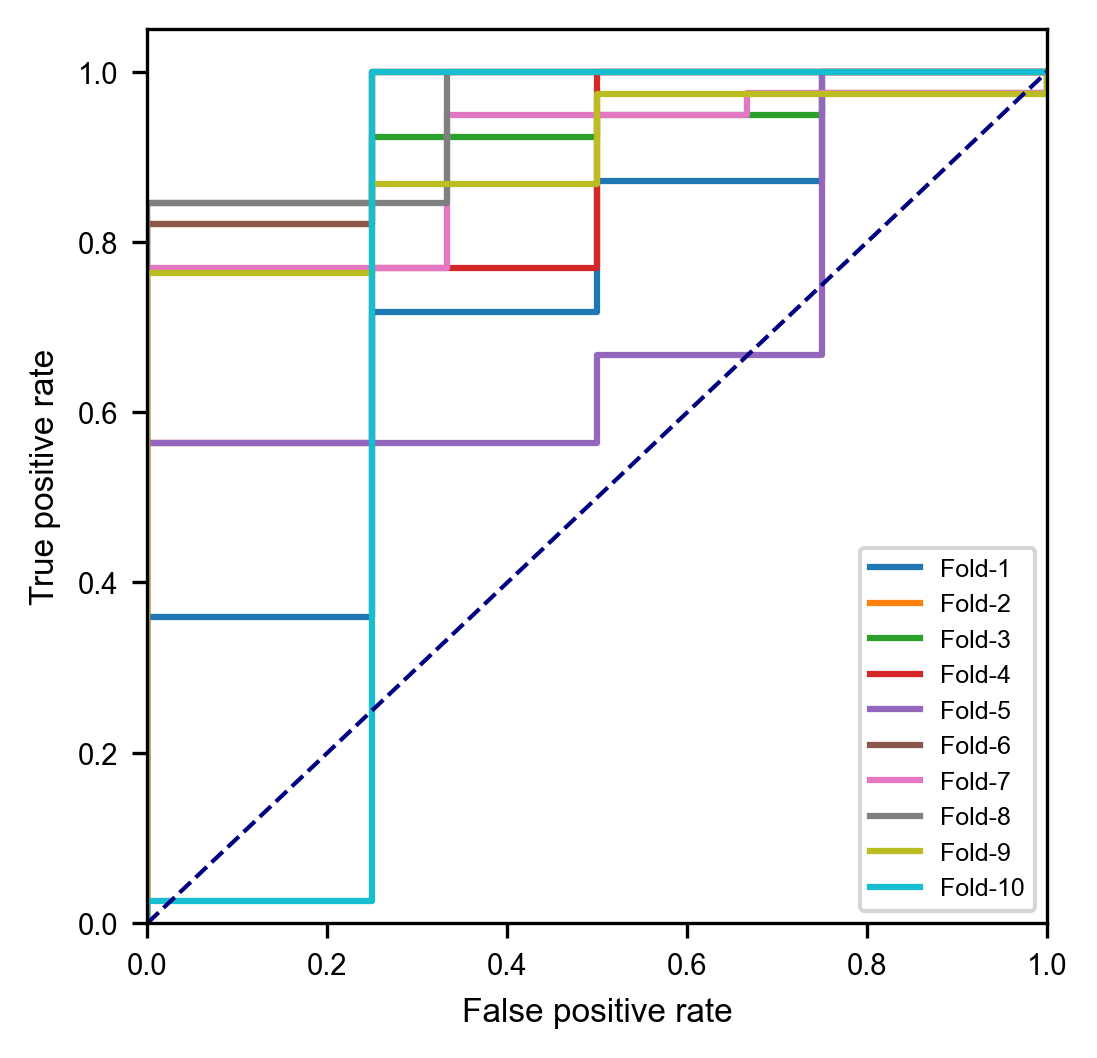

In [10]:
# plot
fig = plt.figure(figsize=(3.87,3.87), dpi=300)

# valid roc
ax = fig.add_subplot(111)
for k, d in enumerate(roc_data,1):
    ax.plot(d[0], d[1], label=f'Fold-{k}')  #  (auc={auc:.4f})
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False positive rate', fontdict={'fontsize':8})
ax.set_ylabel('True positive rate', fontdict={'fontsize':8})
ax.tick_params(labelsize=7)
# ax.set_title('Receiver Operating Curve of Valid Dataset')
# ax.set_title('Receiver Operating Curve of Test Dataset')
ax.legend(fontsize=6)

plt.savefig('./figures/Gevers_roc_curve.png', dpi=300)
plt.show()

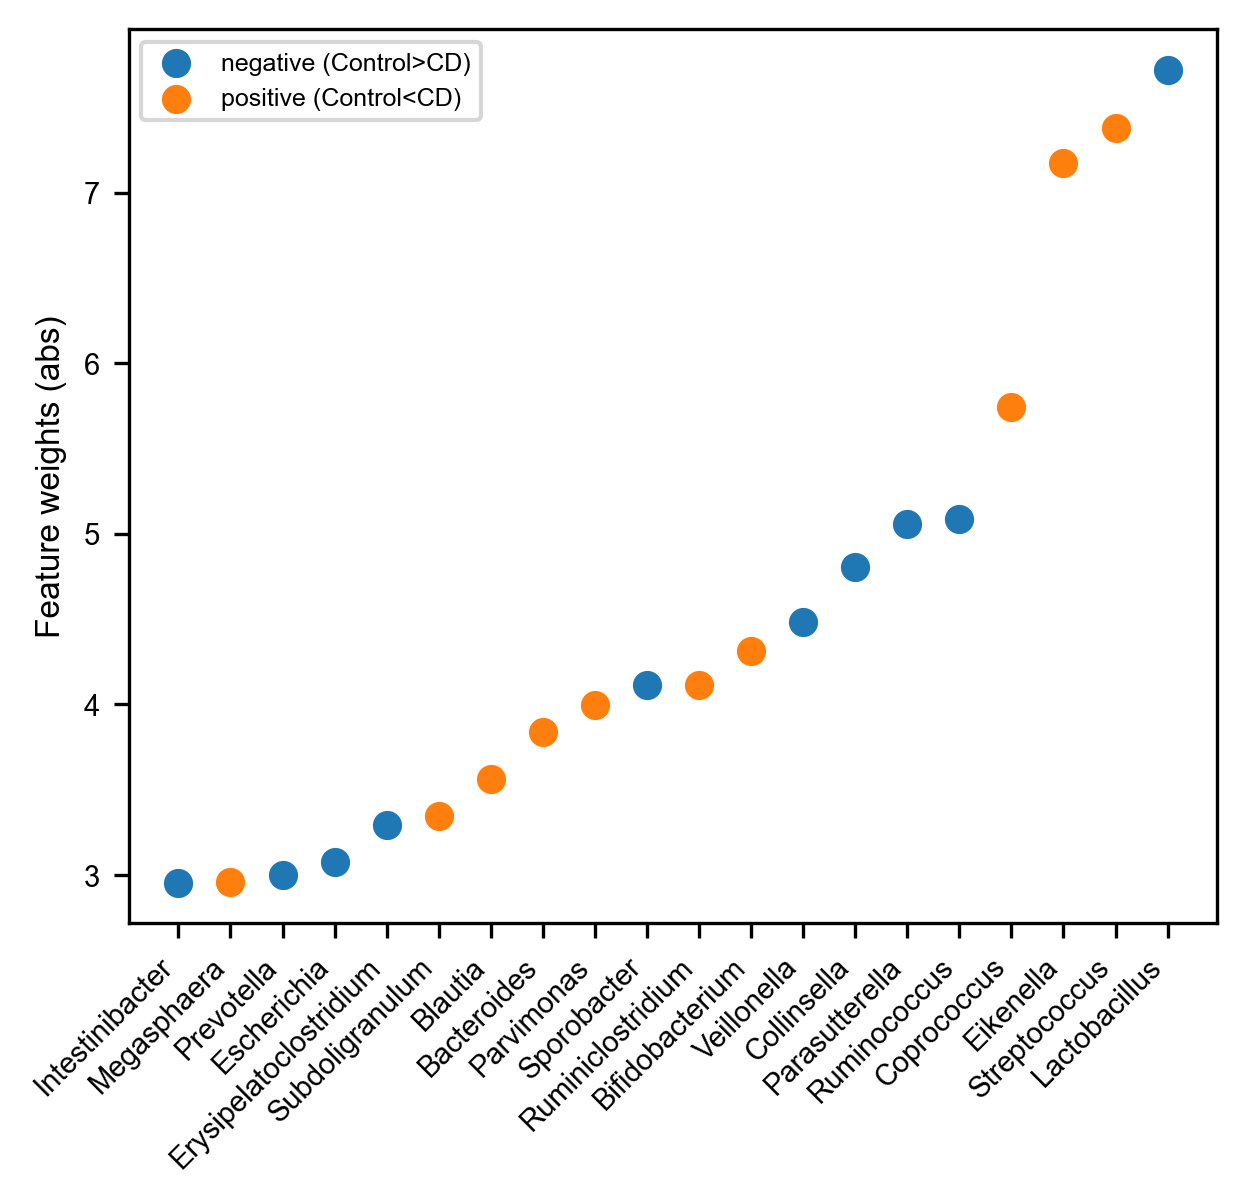

In [11]:
abs_rank = np.abs(mean_weights).argsort()

x_labels = []

pos_y, pos_x, neg_y, neg_x = [], [], [], []
for i, index in enumerate(abs_rank[-20:]):
    x_labels.append(Gevers_data.columns.tolist()[index])
    if mean_weights[index] > 0:
        pos_y.append(mean_weights[index])
        pos_x.append(i)
    else:
        neg_y.append(-mean_weights[index])
        neg_x.append(i)

plt.figure(figsize=(4.68,3.87), dpi=300)
plt.scatter(neg_x, neg_y, label='negative (Control>CD)')
plt.scatter(pos_x, pos_y, label='positive (Control<CD)')
plt.legend(fontsize=6)
plt.xticks(list(range(len(x_labels))), x_labels, rotation=45, ha='right')
plt.ylabel('Feature weights (abs)', fontdict={'fontsize':8})
plt.tick_params(labelsize=7)
# plt.title('Mean Feature weights (Top20)', fontdict={'fontsize': 9})

plt.savefig('./figures/Gevers_feature_rank.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# repeat for 1000 times
from tqdm import tqdm
mean_weights_list = []
aucs = []
for seed in tqdm(np.random.permutation(10000)[:1000]):
    _, _, mean_weights, mean_auc = classification_kfold(Gevers_data, seed=seed, print_res=False)
    mean_weights_list.append(mean_weights)
    aucs.append(mean_auc)

100%|██████████| 1000/1000 [01:05<00:00, 15.15it/s]


In [13]:
print(np.mean(aucs))
mean_weights = np.stack(mean_weights_list).mean(axis=0)
rank = mean_weights.argsort()
print(list(rank).index(mark))

0.8575272604588394
0


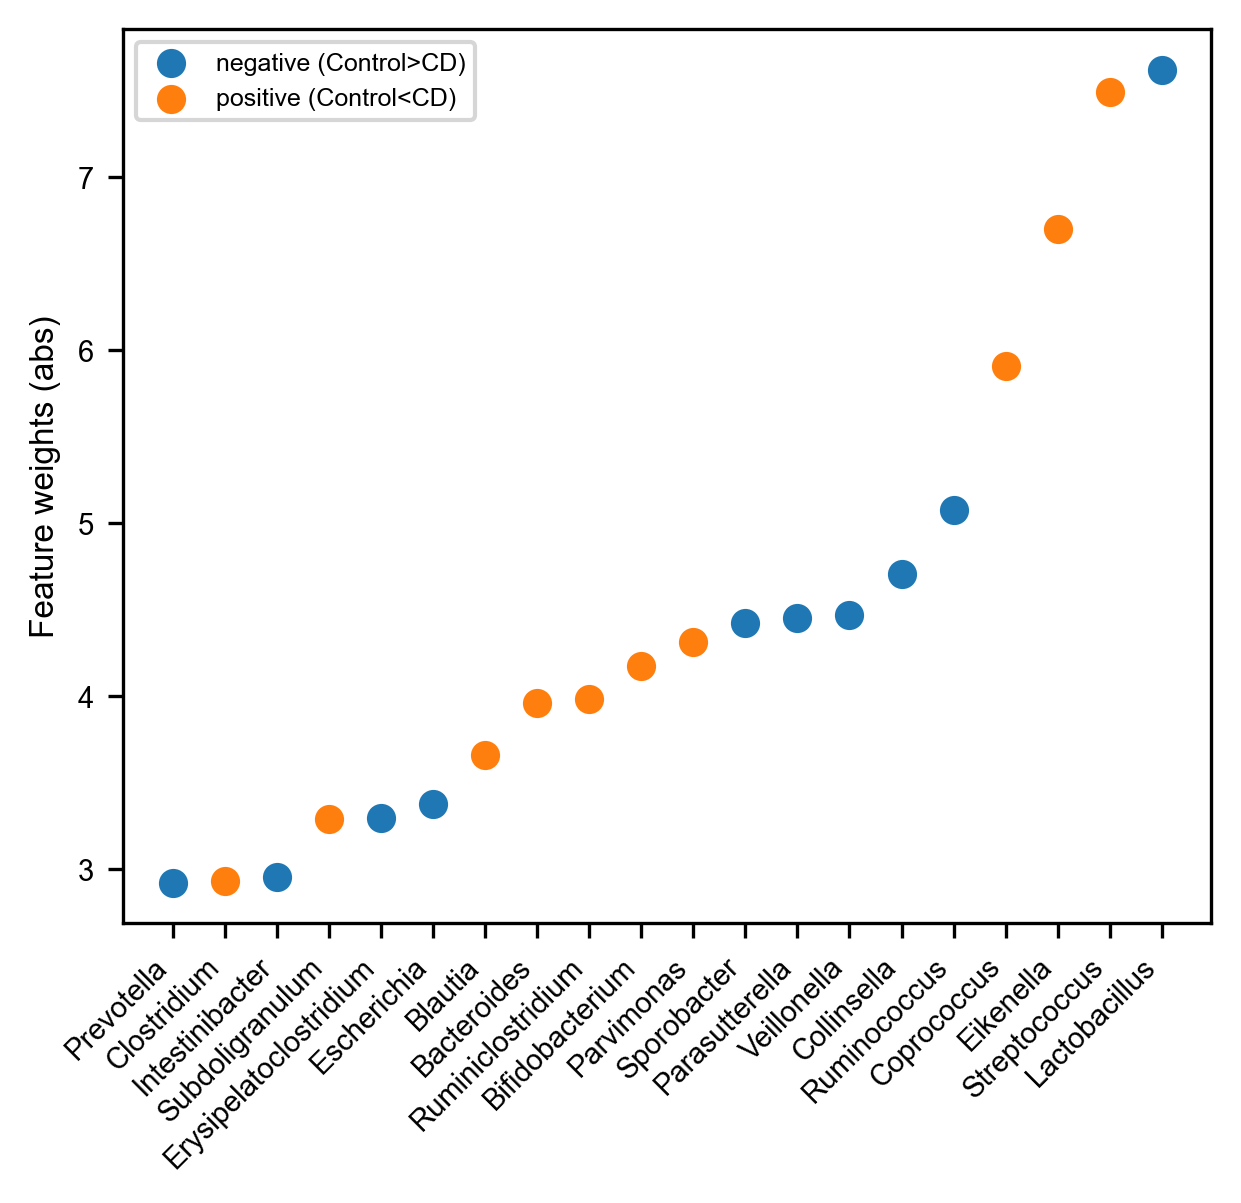

In [14]:
abs_rank = np.abs(mean_weights).argsort()

x_labels = []

pos_y, pos_x, neg_y, neg_x = [], [], [], []
for i, index in enumerate(abs_rank[-20:]):
    x_labels.append(Gevers_data.columns.tolist()[index])
    if mean_weights[index] > 0:
        pos_y.append(mean_weights[index])
        pos_x.append(i)
    else:
        neg_y.append(-mean_weights[index])
        neg_x.append(i)

plt.figure(figsize=(4.68,3.87), dpi=300)
plt.scatter(neg_x, neg_y, label='negative (Control>CD)')
plt.scatter(pos_x, pos_y, label='positive (Control<CD)')
plt.legend(fontsize=6)
plt.xticks(list(range(len(x_labels))), x_labels, rotation=45, ha='right')
plt.ylabel('Feature weights (abs)', fontdict={'fontsize':8})
plt.tick_params(labelsize=7)
# plt.title('Mean Feature weights (Top20)', fontdict={'fontsize': 9})

plt.savefig('./figures/Gevers_feature_rank_1000times.png', dpi=300, bbox_inches='tight')
plt.show()

### Using Gevers data as an outer test set

In [10]:
# load GMrepo data back
raw_info = pd.read_excel('./RawData/Ours/remove_missing.xlsx', sheet_name='Sheet1', index_col=1)
hd_data = raw_info.iloc[:, 1:314]  # 313 samples
uc_data = raw_info.iloc[:, 317:]  # 299 samples
print(hd_data.shape, uc_data.shape)
GMrepo_data = pd.concat([hd_data, uc_data], axis=1).T
print(GMrepo_data.shape)

GMrepo_data = GMrepo_data.reset_index(drop=True)
# HD as 0, UC as 1
GMrepo_data['label'] = [0] * hd_data.shape[1] + [1] * uc_data.shape[1]
print(GMrepo_data.shape)

(62, 313) (62, 299)
(612, 62)
(612, 63)


In [11]:
# merge
Gevers_data_new = np.empty((len(Gevers_data), GMrepo_data.shape[1]), dtype=np.float32)
for i, col in enumerate(GMrepo_data.columns.tolist()):
    if col in Gevers_data.columns.tolist():
        if col != 'label':
            Gevers_data_new[:, i] = np.array(Gevers_data[col].values, dtype=np.float32)
        else:
            # label column no need for multiplying 100
            Gevers_data_new[:, i] = np.array(Gevers_data[col].values, dtype=np.int64)
    else:
        Gevers_data_new[:, i] = np.nan

Gevers_data_new_df = pd.DataFrame(Gevers_data_new, columns=GMrepo_data.columns.tolist())
Gevers_data_new_df.shape

(426, 63)

In [12]:
# using C=10, penalty='l1' as hyperparameters
def classification_final_kfold(all_data, outer_test_data, seed, print_res=True):
    features = all_data.iloc[:, :-1].values
    labels = all_data.iloc[:, -1].values

    # outer X, y
    outer_test_x = outer_test_data.iloc[:, :-1].values
    outer_test_y = outer_test_data.iloc[:, -1].values

    outer_logits_list = []
    # using KFold
    kf = KFold(n_splits=10, shuffle=True, random_state=seed)
    for train_index, test_index in kf.split(features):
        train_x, _ = features[train_index], features[test_index]
        train_y, _ = labels[train_index], labels[test_index]

        scaler = MinMaxScaler(feature_range=(0,1), clip=True)
        pipe = Pipeline([('impute', SimpleImputer(strategy='constant', fill_value=0.)), ('scaler', scaler)])
        X = pipe.fit_transform(train_x)
        outer_X = pipe.transform(outer_test_x)

        model = LogisticRegression(penalty='l1', C=10, solver='liblinear', random_state=seed, max_iter=1000)
        model.fit(X, train_y)
        
        outer_logits = model.predict_proba(outer_X)[:, 1]
        outer_logits_list.append(outer_logits)
        outer_auc = roc_auc_score(outer_test_y, outer_logits)
        if print_res:
            print(outer_auc)

    mean_outer_logits = np.mean(np.stack(outer_logits_list, axis=0), axis=0)
    mean_outer_auc = roc_auc_score(outer_test_y, mean_outer_logits)
    if print_res:
        print('average outer auc:', mean_outer_auc)
    fpr, tpr, _ = roc_curve(outer_test_y, mean_outer_logits)

    return mean_outer_auc, (fpr, tpr)

In [13]:
# one 10-fold cross validation
mean_outer_auc, (fpr, tpr) = classification_final_kfold(GMrepo_data, Gevers_data_new_df, seed=42)

0.6700352685838308
0.6639310906131308
0.6934346174715138
0.694519804666305
0.7020482908301682
0.6716630493760174
0.6910607704829084
0.6709169831795985
0.692078133478025
0.6755290287574607
average outer auc: 0.6817688551275095


In [14]:
# 1000 times 10-fold cross validation
from tqdm import tqdm
mean_outer_aucs = []
outer_auc_data = []
for seed in tqdm(np.random.permutation(10000)[:1000]):
    mean_outer_auc, (fpr, tpr) = classification_final_kfold(GMrepo_data, Gevers_data_new_df, seed=seed, print_res=False)
    mean_outer_aucs.append(mean_outer_auc)
    outer_auc_data.append((fpr, tpr))
print(np.mean(mean_outer_aucs))

100%|██████████| 1000/1000 [04:08<00:00,  4.03it/s]

0.6805080032555617


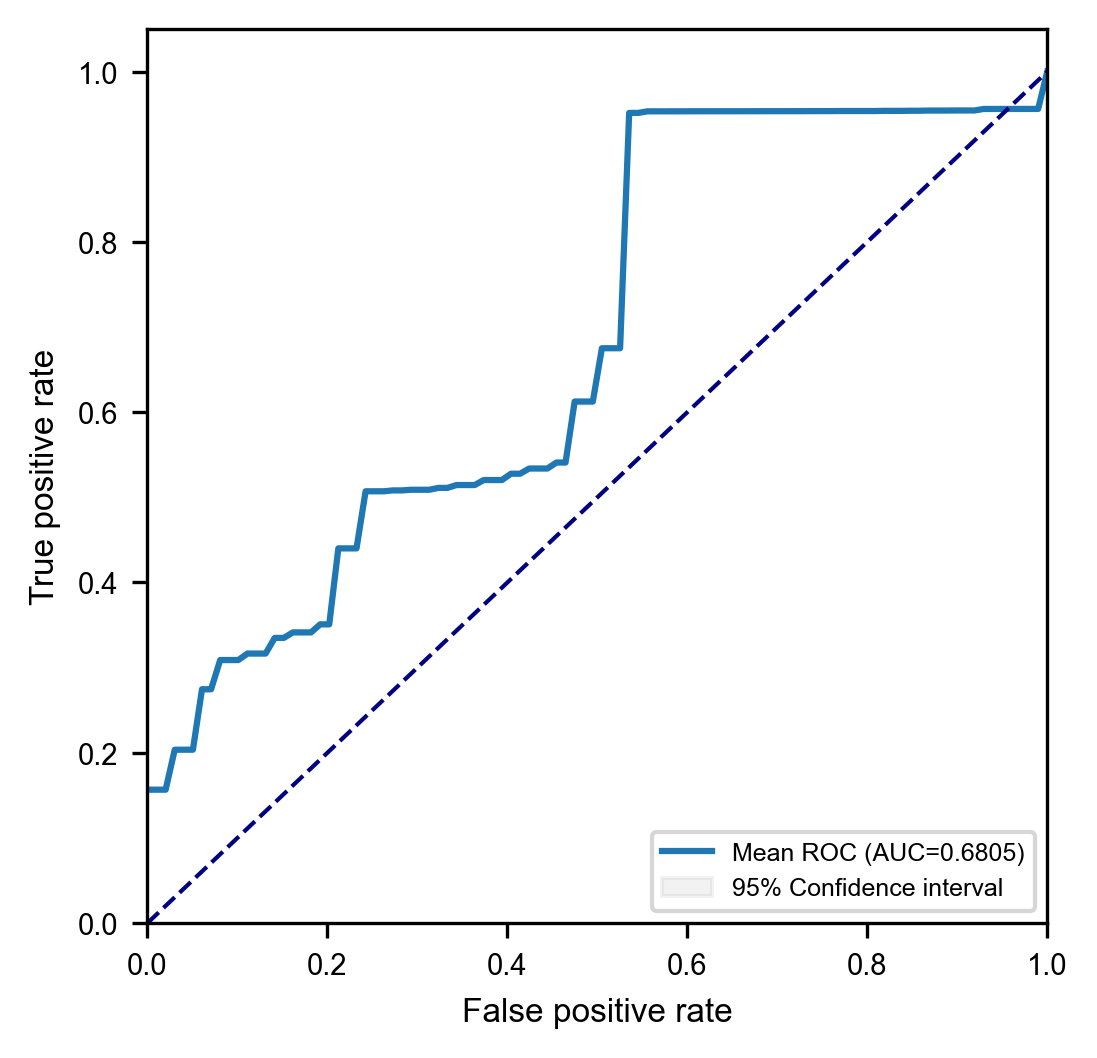

In [16]:
# plot
fig = plt.figure(figsize=(3.87,3.87), dpi=300)

# valid roc
ax = fig.add_subplot(111)
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in outer_auc_data], axis=0)
# 计算置信区间
tpr_std = np.std([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in outer_auc_data], axis=0)
tpr_upper = np.minimum(mean_tpr + 1.96 * tpr_std / np.sqrt(1000), 1)
tpr_lower = mean_tpr - 1.96 * tpr_std / np.sqrt(1000)
# 绘制平均ROC曲线
plt.plot(mean_fpr, mean_tpr, label='Mean ROC (AUC=0.6805)')
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.1, label='95% Confidence interval')
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False positive rate', fontdict={'fontsize':8})
ax.set_ylabel('True positive rate', fontdict={'fontsize':8})
ax.tick_params(labelsize=7)
# ax.set_title('Receiver Operating Curve of Valid Dataset')
# ax.set_title('Receiver Operating Curve of Test Dataset')
ax.legend(fontsize=6, loc='lower right')

plt.savefig('./figures/Gevers_outer_test_mean_roc_curve.png', dpi=300)
plt.show()